# Model Training With Heart Disease Dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder , OrdinalEncoder , StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("Heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,Target
0,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,1
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    int64  
 12  Thal       301 non-null    object 
 13  Target     303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


### Cleaning Data

In [6]:
df = df.dropna()

In [7]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_cols = numeric_df.columns 

for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df[col] = np.clip(df[col], lower_limit, upper_limit)

## Handling Categorical Data 

In [8]:
print(df['ChestPain'].unique())
print(df['Thal'].unique())

['typical' 'asymptomatic' 'nonanginal' 'nontypical']
['fixed' 'normal' 'reversable']


### Which Encoding types should I use?

    In our dataset we can see that Thal , RestECG, Slope , Ca and ChestPain columns are categorical columns. Even though some of them can look like numerical. (like RestECG, Slope , Ca) They doesn't have meanings like numerical columns. We have to encode them. 

1. For Thal - RestECG - Chestpain I'm gonna use one_hot and label for different models.
2. Slope has a real order. So I'm gonna use ordinal encoding (with both of the dataset)

In [9]:
df_one_hot = pd.get_dummies(df , columns = ["Thal", "RestECG" , "ChestPain"] , dtype = int)
df_one_hot.head(3)

,Age,Sex,RestBP,Chol,Fbs,MaxHR,ExAng,Oldpeak,Slope,Ca,...,Thal_fixed,Thal_normal,Thal_reversable,RestECG_0,RestECG_1,RestECG_2,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical
0,63,1,145,233,0,150,0,2.3,3,0.0,...,1,0,0,0,0,1,0,0,0,1
1,67,1,160,286,0,108,1,1.5,2,2.5,...,0,1,0,0,0,1,1,0,0,0
2,67,1,120,229,0,129,1,2.6,2,2.0,...,0,0,1,0,0,1,1,0,0,0


In [10]:
le = LabelEncoder()
df_label = df.copy()

for col in ["Thal" , "RestECG" , "ChestPain" ]:
    df_label[col] = le.fit_transform(df[col])

df_label.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,Target
0,63,1,3,145,233,0,2,150,0,2.3,3,0.0,0,0
1,67,1,0,160,286,0,2,108,1,1.5,2,2.5,1,1
2,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1


In [11]:
ordinal_encoder = OrdinalEncoder()
datasets = {
    "label": df_label,
    "onehot": df_one_hot
}
for name in datasets:
    datasets[name]['Slope'] = ordinal_encoder.fit_transform(datasets[name][['Slope']])

    Right now, we have two different datasets. We are going to split both of them into training and test sets to train our model.

### Spliting Datasets

In [12]:
splits = {}
for name, data in datasets.items():

    X = data.drop("Target", axis=1)
    y = data["Target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=111 if name=="label" else 100
    )

    splits[name] = {
        "X_train": X_train.copy(),
        "X_test": X_test.copy(),
        "y_train": y_train,
        "y_test": y_test
    }

### Feature Scaling

In [13]:
continuous_cols = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']

standard = StandardScaler()
minmax = MinMaxScaler()

for name, data in splits.items():
    scaler = standard if name == "label" else minmax
    
    data["X_train"][continuous_cols] = scaler.fit_transform(data["X_train"][continuous_cols])
    data["X_test"][continuous_cols] = scaler.transform(data["X_test"][continuous_cols])

## Training and Evaluating Models

For evaluating and training we can create a functions because we are going to do the same thing over and over again. It would be waste of time if we don't use functions

In [14]:
def fit_data( splits , label_model , onehot_model):
    for name , data in splits.items() :
        lr = label_model if name == "label" else onehot_model 
        lr.fit(data["X_train"] , data["y_train"])

def evaluate_model(name ,model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"{name} dataset :")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

def evaluate_data( splits , label_model , onehot_model ) :
    for name , data in splits.items() :
        lr = label_model if name == "label" else onehot_model
        evaluate_model(name , lr, data["X_test"] , data["y_test"])
        print("--------------------------------------------------------------")


### 1. Logicstic Regression

First of all we have to fit our data for our model using train sets.

In [48]:
label_lr = LogisticRegression(max_iter=1000)
onehot_lr = LogisticRegression(max_iter=1000, solver='liblinear')

fit_data(splits , label_lr , onehot_lr )
evaluate_data(splits , label_lr , onehot_lr)

label dataset :
Accuracy: 0.819672131147541

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        36
           1       0.79      0.76      0.78        25

    accuracy                           0.82        61
   macro avg       0.81      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61


Confusion Matrix:
 [[31  5]
 [ 6 19]]

ROC-AUC: 0.9266666666666666
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.8360655737704918

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        30
           1       0.96      0.71      0.81        31

    accuracy                           0.84        61
   macro avg       0.86      0.84      0.83        61
weighted avg       0.86      0.84      0.83        61


Confusion Matrix:
 [[29  1]
 [ 9 22]]

ROC-AUC: 0.9408602150537635
-------

### 2. Decision Tree

In [44]:
label_dt= DecisionTreeClassifier()
onehot_dt = DecisionTreeClassifier()

fit_data(splits , label_dt , onehot_dt )
evaluate_data(splits , label_dt , onehot_dt)

label dataset :
Accuracy: 0.8032786885245902

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82        36
           1       0.71      0.88      0.79        25

    accuracy                           0.80        61
   macro avg       0.80      0.81      0.80        61
weighted avg       0.82      0.80      0.80        61


Confusion Matrix:
 [[27  9]
 [ 3 22]]

ROC-AUC: 0.815
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.6721311475409836

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70        30
           1       0.72      0.58      0.64        31

    accuracy                           0.67        61
   macro avg       0.68      0.67      0.67        61
weighted avg       0.68      0.67      0.67        61


Confusion Matrix:
 [[23  7]
 [13 18]]

ROC-AUC: 0.6736559139784946
-------------------

### 3. Support Vector Machine

In [45]:
label_svm = SVC(probability = True)
onehot_svm = SVC(probability = True)

fit_data(splits , label_svm, onehot_svm )
evaluate_data(splits , label_svm , onehot_svm)

label dataset :
Accuracy: 0.8688524590163934

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89        36
           1       0.87      0.80      0.83        25

    accuracy                           0.87        61
   macro avg       0.87      0.86      0.86        61
weighted avg       0.87      0.87      0.87        61


Confusion Matrix:
 [[33  3]
 [ 5 20]]

ROC-AUC: 0.9288888888888889
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.8032786885245902

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82        30
           1       0.91      0.68      0.78        31

    accuracy                           0.80        61
   macro avg       0.82      0.81      0.80        61
weighted avg       0.83      0.80      0.80        61


Confusion Matrix:
 [[28  2]
 [10 21]]

ROC-AUC: 0.9225806451612905
------

### 4. Random Forest Classifier 

In [46]:
label_rfc = RandomForestClassifier()
onehot_rfc = RandomForestClassifier()

fit_data(splits , label_rfc , onehot_rfc )
evaluate_data(splits , label_rfc , onehot_rfc)

label dataset :
Accuracy: 0.8524590163934426

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        36
           1       0.79      0.88      0.83        25

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61


Confusion Matrix:
 [[30  6]
 [ 3 22]]

ROC-AUC: 0.9311111111111111
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.8524590163934426

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.92      0.77      0.84        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61


Confusion Matrix:
 [[28  2]
 [ 7 24]]

ROC-AUC: 0.910752688172043
-------

The best performance models are Random Forest with label dataset and logistic regression model with one-hot dataset.

## Hyperparameter Tuning and Feature Importance

First we have to select the parameters for both of the models. Then we will use these parameters to find the best parameters for the Random Forest model.

### 1. Random Forest

In [19]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [20]:
RandomForestGrid = GridSearchCV(
    label_rfc,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

RandomForestGrid.fit(splits["label"]["X_train"], splits["label"]["y_train"])
print(RandomForestGrid.best_params_)

{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [21]:
best_model_rfc = RandomForestGrid.best_estimator_
evaluate_model("Tuned_Random_Forest", best_model_rfc , splits["label"]["X_test"] ,  splits["label"]["y_test"])

Tuned_Random_Forest dataset :
Accuracy: 0.8852459016393442

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.85      0.88      0.86        25

    accuracy                           0.89        61
   macro avg       0.88      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61


Confusion Matrix:
 [[32  4]
 [ 3 22]]

ROC-AUC: 0.9422222222222222


The recall and ROC-AUC score rises with the parameter we find using GridSearchCV.

In [23]:
importance_rf = pd.DataFrame({
    "feature" : splits["label"]["X_train"].columns,
    "importance" : best_model_rfc.feature_importances_
}).sort_values("importance", ascending=False)

print(importance_rf)

      feature  importance
11         Ca    0.147451
7       MaxHR    0.142221
12       Thal    0.122847
2   ChestPain    0.116930
9     Oldpeak    0.113561
0         Age    0.084847
8       ExAng    0.073129
10      Slope    0.061223
4        Chol    0.048592
3      RestBP    0.042320
1         Sex    0.032711
6     RestECG    0.014166
5         Fbs    0.000000


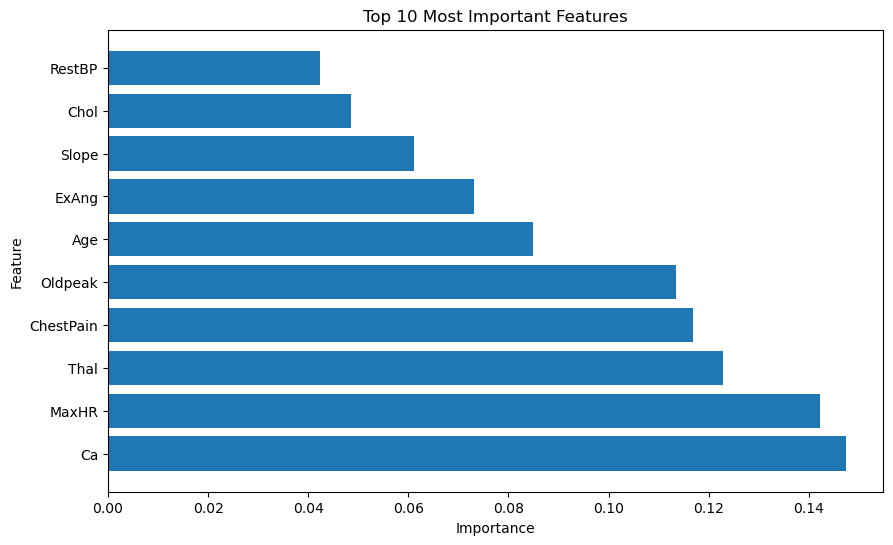

<Figure size 1000x600 with 0 Axes>

In [41]:
top_features = importance_rf.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_features["feature"], top_features["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.figure(figsize=(10, 6))

plt.show()

### 2. Logistic Regression

Now lets try hyperparameter tuning on logistic Regression and see the difference between them.

In [25]:
param_grid ={
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','liblinear'],
    'max_iter'  : [100,1000,2500,5000],
    'class_weight' : ['balanced']
}

In [26]:
LogisticRegressionGrid = GridSearchCV(
    label_lr , 
    param_grid , 
    cv = 5 ,
    scoring = "roc_auc",
    n_jobs = -1 ,
)
LogisticRegressionGrid.fit(splits["onehot"]["X_train"], splits["onehot"]["y_train"])
print(LogisticRegressionGrid.best_params_)

{'C': np.float64(0.004832930238571752), 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}


In [27]:
best_model_lr = LogisticRegressionGrid.best_estimator_
evaluate_model("Tuned_Logistic_Regression", best_model_lr , splits["onehot"]["X_test"] ,  splits["onehot"]["y_test"])

Tuned_Logistic_Regression dataset :
Accuracy: 0.8524590163934426

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.92      0.77      0.84        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61


Confusion Matrix:
 [[28  2]
 [ 7 24]]

ROC-AUC: 0.9419354838709677


In [31]:
features = splits["onehot"]["X_train"].columns

coeffs = best_model_lr.coef_[0]

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coeffs,
    "abs_value": np.abs(coeffs)
}).sort_values(by="abs_value", ascending=False)

print(coef_df)

                   feature  coefficient  abs_value
9                       Ca     0.167828   0.167828
11             Thal_normal    -0.124392   0.124392
16  ChestPain_asymptomatic     0.123578   0.123578
12         Thal_reversable     0.114559   0.114559
6                    ExAng     0.089925   0.089925
8                    Slope     0.083076   0.083076
17    ChestPain_nonanginal    -0.072789   0.072789
1                      Sex     0.062337   0.062337
7                  Oldpeak     0.049737   0.049737
13               RestECG_0    -0.041706   0.041706
15               RestECG_2     0.038550   0.038550
18    ChestPain_nontypical    -0.037288   0.037288
5                    MaxHR    -0.036405   0.036405
0                      Age     0.020469   0.020469
19       ChestPain_typical    -0.013425   0.013425
2                   RestBP     0.012277   0.012277
3                     Chol     0.010557   0.010557
10              Thal_fixed     0.009909   0.009909
14               RestECG_1     

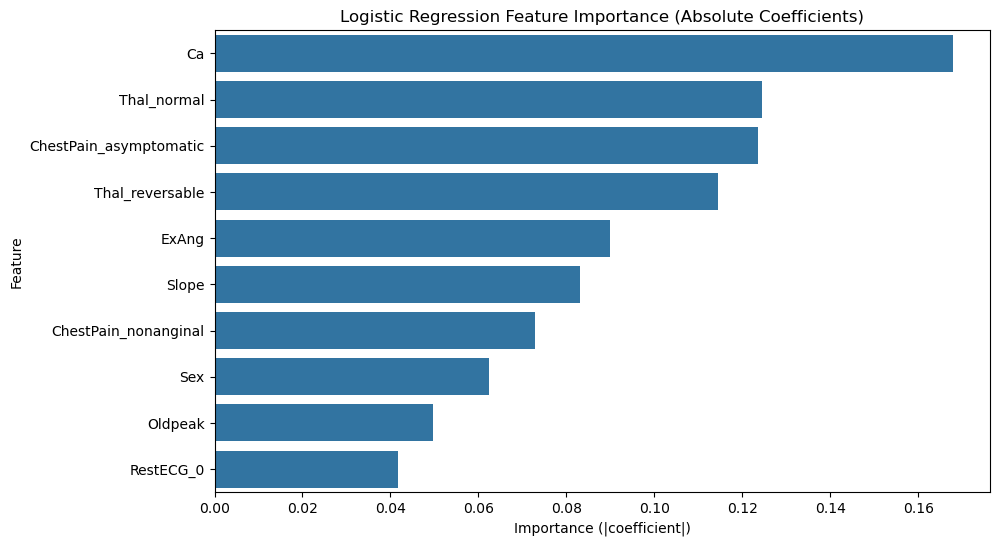

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df.head(10), 
    x="abs_value", 
    y="feature"
)
plt.title("Logistic Regression Feature Importance (Absolute Coefficients)")
plt.xlabel("Importance (|coefficient|)")
plt.ylabel("Feature")
plt.show()

# MODEL TRAINING ANALYSIS

### Encoding and Model Training Report

    Our dataset is small and not very noisy. After trying both label encoding and one-hot encoding on four different models, we observed that our tree-based models (Decision Tree and Random Forest) performed worse with one-hot encoding. This happened because one-hot encoding increases the number of features, and tree-based models generally perform better when the number of features is smaller. We can clearly see this difference when comparing the results of tree models on the label-encoded dataset versus the one-hot-encoded dataset. 

    However, with Logistic Regression, the one-hot-encoded dataset performed better than the label-encoded one. This is because label encoding forces the model to interpret categorical values as if they have an ordinal relationship, even when they don’t. This incorrect ordering harms the model’s performance. With one-hot encoding, the categorical variables are represented correctly, and the model performs better.

    So we decided to choose label dataset with random forest model and onehot dataset with logistic regression for hyperparameter tuning.

### Hyperparameter Tuning and Feature Importance

    We found the best hyperparameters for both models using GridSearchCV. The most interesting metric for me was recall in the Logistic Regression model. Its recall values were not as balanced as those of the Random Forest model (0.93 vs. 0.77). Since in our dataset the priority is to correctly identify people with heart disease, a higher recall for positive class is crucial. Random Forest produced more true positives than Logistic Regression. That's why I would prefer to use random forest model.

    When we look at the important-features graphs for both models, we can see that they are almost similar to each other (for example, Ca, Thal, and ChestPain appear in both). In fact, there is also some similarity between these results and the important features I identified in Task 1.

    However, there are a few differences. In Task 1, MaxHR, Oldpeak, ExAng, and Ca appeared to be the most important features. These new graphs suggest that other features may also be more influential than I initially expected. This happens because in Task 1 I only used the correlation matrix and a few bar charts I created, so my earlier interpretation was limited.I overlooked some of the nonlinear relationships that the models are now capturing.

In [52]:
feature_importance = pd.DataFrame({"logistic regression" : coef_df["feature"].head(5) ,
                                   "random forest" : top_features["feature"]})

In [53]:
feature_importance

,logistic regression,random forest
0,NaN,Age
2,NaN,ChestPain
3,NaN,RestBP
4,NaN,Chol
6,ExAng,NaN
7,NaN,MaxHR
8,NaN,ExAng
9,Ca,Oldpeak
10,NaN,Slope
11,Thal_normal,Ca
